In [ ]:
%%capture
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Audio_Sentiment_Analysis/iemocap

In [ ]:
%%capture
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa
import librosa.display
import time
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier as RandomForest, HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Bidirectional, Reshape, Lambda, Activation, Dense, LSTM, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from PIL import Image
from glob import glob
from tabulate import tabulate
from pprint import pprint
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pickle
from keras.callbacks import Callback

AUTOTUNE = tf.data.AUTOTUNE

AUDIO_MEL_SPECTROGRAM_IMAGES_DIR = './data/mel_spectrogram_images/'

OneHotEncodingConfig = {'0': [1, 0, 0, 0], '1': [0, 1, 0, 0], '2': [0, 0, 1, 0], '3': [0, 0, 0, 1]}
plt.rcParams['figure.dpi'] = 300

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=8fcafbb4d0981612f23187c43cda2e4f309d30a7cab37fd764cbacc07e1fc77d
  Stored in directory: /root/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 86.1 GB  | Proc size: 1.5 GB
GPU RAM Free: 39858MB | Used: 655MB | Util   2% | Total 40960MB


In [ ]:
def get_metrics(y_labels, y_pred, train_times, prediction_times, draw_corr_matrix=True):
    folds_size = 1107
    accs = []
    i = 0
    for f_i in range(5):
      acc = round(metrics.accuracy_score(
          y_labels[i:i+folds_size], y_pred[i:i+folds_size]) * 100, 2)
      print(f"Accuracy for fold {f_i}: {acc}%")
      accs.append(acc)

      i += folds_size

      if f_i == 0:
        folds_size = 1106

    table = [
        ["Accuracy",
            f"{round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)}+-{round(np.std(accs), 2)}"],
        ["F1 score macro", round(metrics.f1_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Precision", round(metrics.precision_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Recall", round(metrics.recall_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Matthews corrcoef", round(
            metrics.matthews_corrcoef(y_labels, y_pred), 3)],
        ["Training Time", f"{round(np.sum(train_times), 2)}+-{round(np.std(train_times), 2)}"],
        ["Prediction Time", f"{round(np.sum(prediction_times), 2)}+-{round(np.std(prediction_times), 2)}"],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))
    print()
    print(metrics.classification_report(y_labels, y_pred))

    if draw_corr_matrix:
        ticks = ['0 - angry', '1 - happy', '2 - neutral', '3 - sad']
        cm = metrics.confusion_matrix(y_labels, y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d",
                    xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()


In [ ]:
class ADJUSTLR(Callback):
    def __init__ (self, model, verbose):
        self.model = model
        self.freq = 5
        self.factor = .9
        self.verbose = verbose
        self.adj_epoch = 5
    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 == self.adj_epoch: # adjust the learning rate
            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
            new_lr=lr * self.factor
            self.adj_epoch +=self.freq
            if self.verbose == 1:
                print('\non epoch ',epoch + 1, ' lr was adjusted from ', lr, ' to ', new_lr)
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer


def categorical_cross_validation(get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)

  all_y_pred = []
  all_y_labels = []

  training_times = []
  prediction_times = []

  X = data_df.iloc[:]
  y = data_df.iloc[:, 1]

  fold_no = 1
  for train, test in kfold.split(X, y):
    model = get_new_model()

    train_ds = X.iloc[train]
    train_ds = preprocess_dataset(train_ds.iloc[:, 0].values)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    
    test_ds = X.iloc[test]
    test_ds = preprocess_dataset(test_ds.iloc[:, 0].values)
    test_ds = test_ds.batch(batch_size)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    print(f'Training for fold {fold_no} ...')
    callback = ADJUSTLR(model, verbosity)

    start_time = time.time()
    model.fit(train_ds,
              validation_data=test_ds,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback],
              workers=-1)
    training_times.append(time.time() - start_time)

    start_time = time.time()
    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      y_pred = [list(x).index(max(x)) for x in y_pred]
      all_y_pred.extend(y_pred)
      y_label = [x[0] for x in label.numpy()]
      all_y_labels.extend(y_label)
    prediction_times.append(time.time() - start_time)

    fold_no = fold_no + 1

  return all_y_labels, all_y_pred, training_times, prediction_times

In [ ]:
def get_y_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    return tf_load_process_image(audio_file), int(audio_file.split("-")[1][0])

def data_loader(filename):
    features, labels = tf.py_function(
        get_y_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [224, 224, 3]), tf.reshape(labels, [1])

def preprocess_dataset(files):
    filenames_ds = tf.data.Dataset.list_files(files)
    return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)

# Mel Spectrogram

In [ ]:
%cd ./data/mel_spectrograms_images
data_df = pd.DataFrame([(file, file[-5]) for file in glob("*.png")])
print(len(data_df))
data_df.head()

/content/drive/MyDrive/Audio_Sentiment_Analysis/iemocap/data/mel_spectrograms_images
5531


,0,1
0,Ses05F_impro06_F007-2-mel_img.png,g
1,Ses05F_impro06_F003-2-mel_img.png,g
2,Ses05F_impro06_F001-2-mel_img.png,g
3,Ses05F_impro06_F004-2-mel_img.png,g
4,Ses05F_impro06_F002-2-mel_img.png,g


## Resnet50

In [ ]:
def get_new_model():
    model = tf.keras.applications.resnet.ResNet50(
        weights="imagenet",
        input_shape=(224, 224, 3),
        include_top=False,
        pooling="avg")
    model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = model(inputs, training=False)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

def tf_load_process_image(filename):
    image_original = load_img(filename, target_size=(224, 224))
    image_array = img_to_array(image_original)
    image_preprocessed = tf.keras.applications.resnet50.preprocess_input(
        image_array)
    return image_preprocessed

get_new_model().summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 23,719,108
Trainable params: 131,396
Non-trainable params: 23,587,712
____________________________________________

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 80
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/80
35/35 [==============================] - 108s 2s/step - loss: 1.4071 - accuracy: 0.3547 - val_loss: 1.1975 - val_accuracy: 0.4354
Epoch 2/80
35/35 [==============================] - 2s 68ms/step - loss: 1.2047 - accuracy: 0.4274 - val_loss: 1.1463 - val_accuracy: 0.4806
Epoch 3/80
35/35 [==============================] - 2s 68ms/step - loss: 1.1427 - accuracy: 0.4699 - val_loss: 1.1173 - val_accuracy: 0.5113
Epoch 4/80
35/35 [==============================] - 2s 68ms/step - loss: 1.1190 - accuracy: 0.4717 - val_loss: 1.0998 - val_accuracy: 0.5077
Epoch 5/80
34/35 [============================>.] - ETA: 0s - loss: 1.1067 - accuracy: 0.4784
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
35/35 [==============================] - 2s 69ms/step - loss: 1.1091 - accuracy: 0.4788 - val_loss: 1.0924 - val_accuracy: 0.5194
Epoch 6/80
35/35 [==============================] - 2s 68ms/step - loss: 1.0927 - accuracy: 0.4910 - val

Accuracy for fold 0: 56.55%
Accuracy for fold 1: 59.76%
Accuracy for fold 2: 59.4%
Accuracy for fold 3: 57.23%
Accuracy for fold 4: 56.78%

Metric             Value
-----------------  --------------
Accuracy           57.95+-1.36
F1 score macro     58.71
Precision          59.27
Recall             58.49
Matthews corrcoef  0.43
Training Time      1133.66+-34.83
Prediction Time    20.92+-0.21

              precision    recall  f1-score   support

           0       0.65      0.59      0.62      1103
           1       0.55      0.48      0.51      1636
           2       0.64      0.64      0.64      1084
           3       0.54      0.63      0.58      1708

    accuracy                           0.58      5531
   macro avg       0.59      0.58      0.59      5531
weighted avg       0.58      0.58      0.58      5531



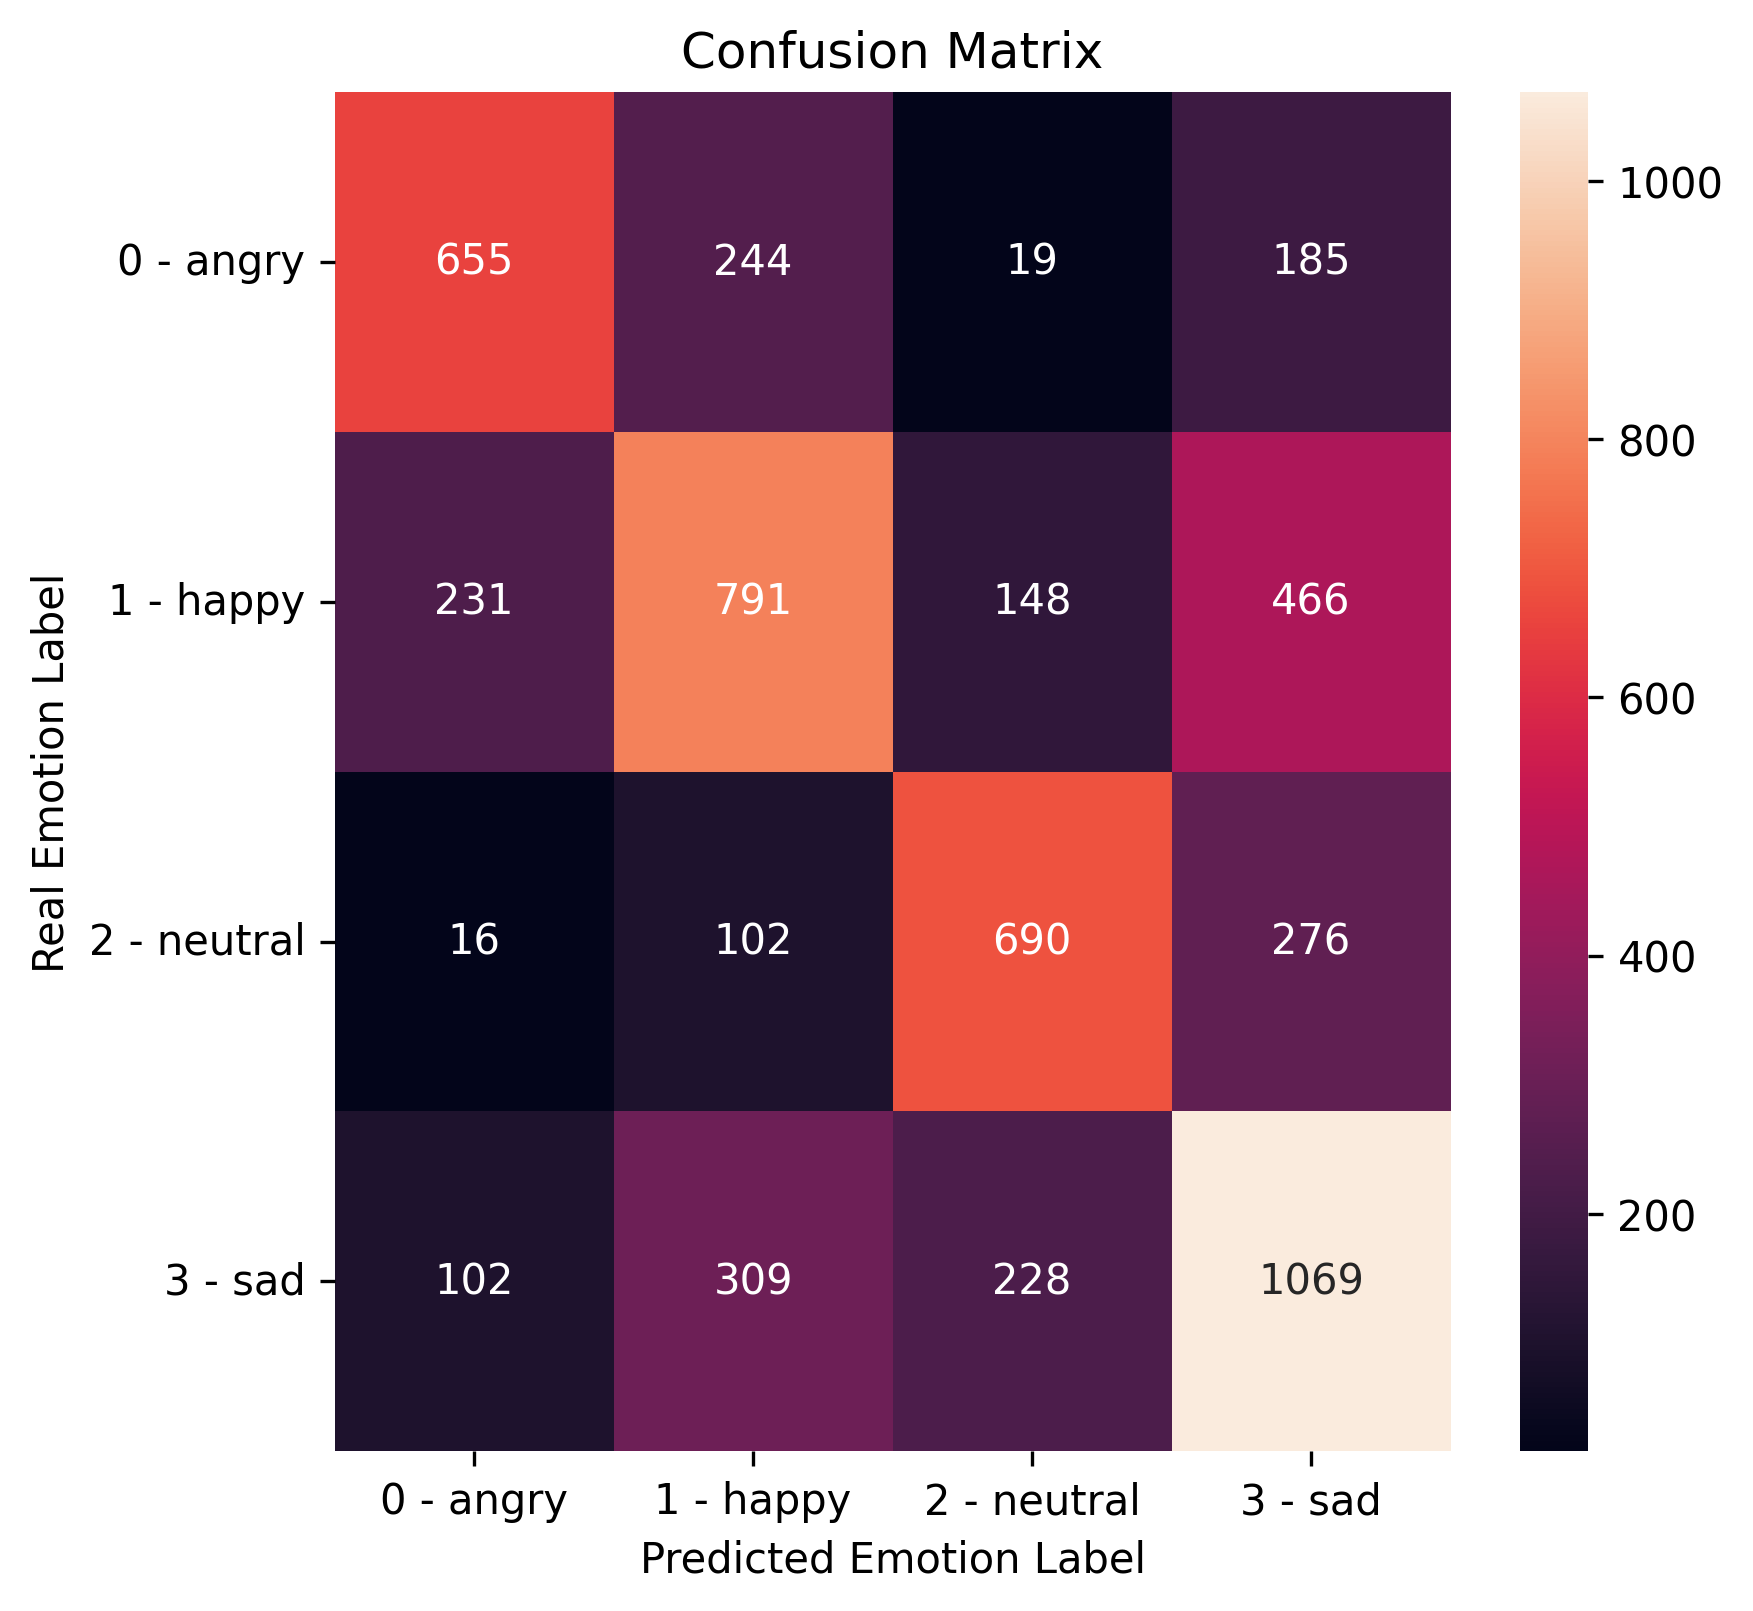

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)

## VGG16

In [ ]:
def get_new_model():
    model = tf.keras.applications.VGG16(
        weights="imagenet",
        input_shape=(224, 224, 3),
        include_top=False,
        pooling="avg")
    model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = model(inputs, training=False)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

def tf_load_process_image(filename):
    image_original = load_img(filename, target_size=(224, 224))
    image_array = img_to_array(image_original)
    image_preprocessed = tf.keras.applications.vgg16.preprocess_input(
        image_array)
    return image_preprocessed

get_new_model().summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 4)                 260       
                                                                 
Total params: 14,747,780
Trainable params: 33,092
Non-trainable params: 14,714,688
___________________________________________

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 80
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/80
35/35 [==============================] - 20s 487ms/step - loss: 1.8873 - accuracy: 0.3126 - val_loss: 1.2901 - val_accuracy: 0.3550
Epoch 2/80
35/35 [==============================] - 2s 67ms/step - loss: 1.2849 - accuracy: 0.3816 - val_loss: 1.2351 - val_accuracy: 0.4029
Epoch 3/80
35/35 [==============================] - 2s 68ms/step - loss: 1.2465 - accuracy: 0.3976 - val_loss: 1.2069 - val_accuracy: 0.4300
Epoch 4/80
35/35 [==============================] - 2s 67ms/step - loss: 1.2124 - accuracy: 0.4304 - val_loss: 1.1880 - val_accuracy: 0.4481
Epoch 5/80
34/35 [============================>.] - ETA: 0s - loss: 1.1742 - accuracy: 0.4465
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
35/35 [==============================] - 2s 68ms/step - loss: 1.1745 - accuracy: 0.4471 - val_loss: 1.1595 - val_accuracy: 0.4770
Epoch 6/80
35/35 [==============================] - 2s 68ms/step - loss: 1.1626 - accuracy: 0.4507 - v

Accuracy for fold 0: 51.85%
Accuracy for fold 1: 58.23%
Accuracy for fold 2: 56.6%
Accuracy for fold 3: 53.62%
Accuracy for fold 4: 55.06%

Metric             Value
-----------------  -------------
Accuracy           55.07+-2.23
F1 score macro     55.82
Precision          56.77
Recall             55.29
Matthews corrcoef  0.389
Training Time      1027.24+-1.44
Prediction Time    12.04+-0.35

              precision    recall  f1-score   support

           0       0.61      0.52      0.56      1103
           1       0.50      0.47      0.49      1636
           2       0.64      0.62      0.63      1084
           3       0.51      0.60      0.55      1708

    accuracy                           0.55      5531
   macro avg       0.57      0.55      0.56      5531
weighted avg       0.55      0.55      0.55      5531



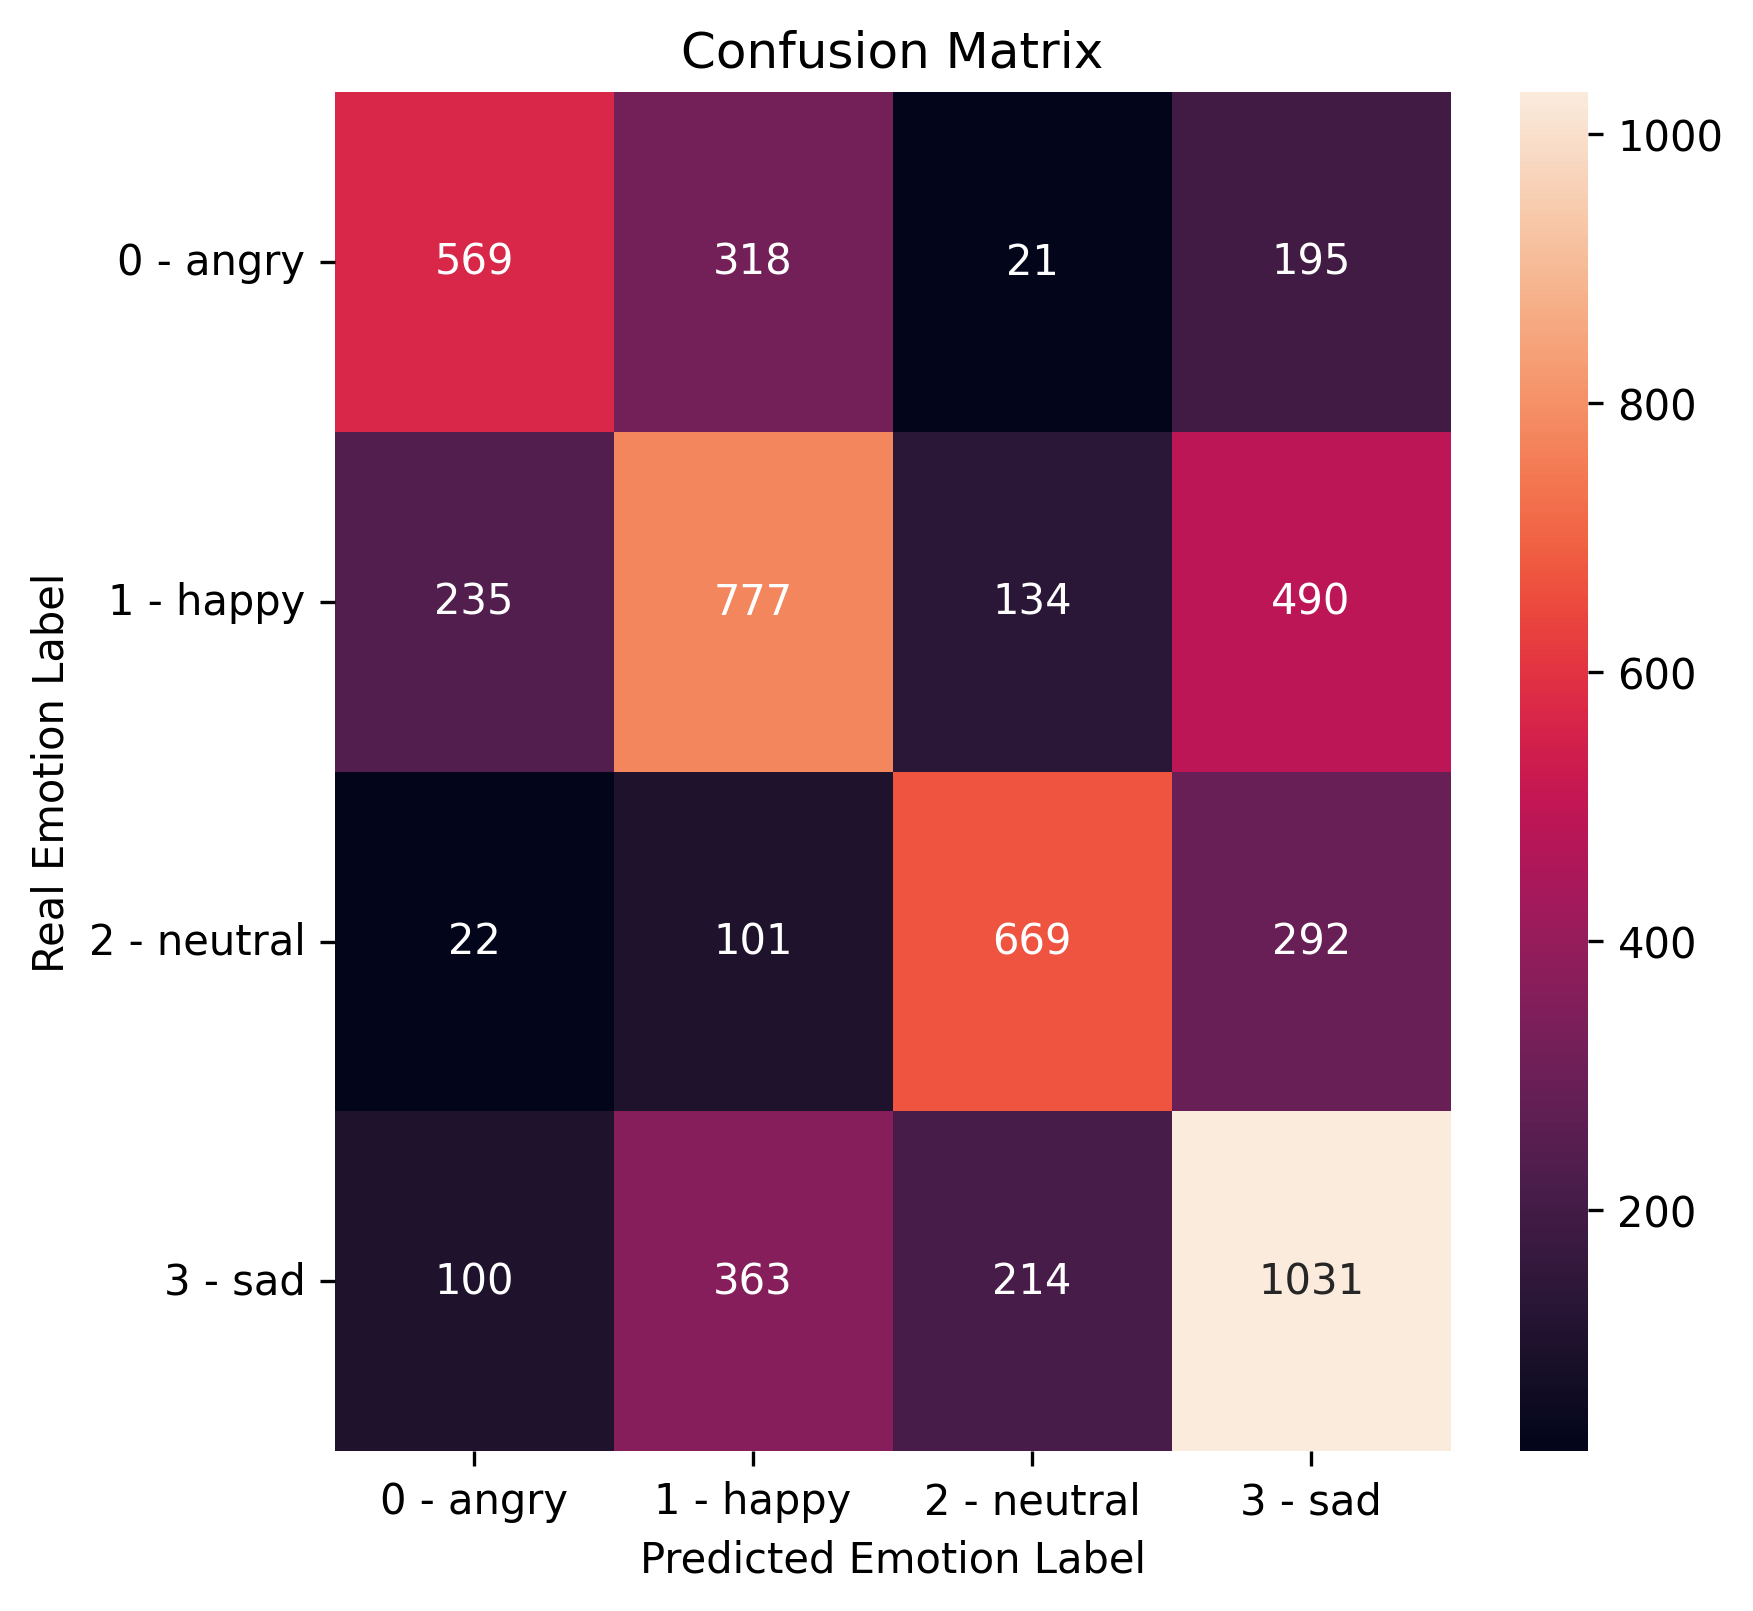

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)

## Xception

In [ ]:
def get_new_model():
    model = tf.keras.applications.Xception(
        weights="imagenet",
        input_shape=(224, 224, 3),
        include_top=False,
        pooling="avg")
    model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = model(inputs, training=False)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

def tf_load_process_image(filename):
    image_original = load_img(filename, target_size=(224, 224))
    image_array = img_to_array(image_original)
    image_preprocessed = tf.keras.applications.xception.preprocess_input(
        image_array)
    return image_preprocessed

get_new_model().summary()

83683744/83683744 [==============================] - 5s 0us/step
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_24 (Dense)            (None, 64)                131136    
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 4)                 260       
                                                                 
Total params: 20,992,876
Trainable params: 131,396
Non-trainable params: 20,861,480
_________________________________________

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 80
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/80
35/35 [==============================] - 21s 473ms/step - loss: 1.2163 - accuracy: 0.4265 - val_loss: 1.1409 - val_accuracy: 0.5041
Epoch 2/80
35/35 [==============================] - 3s 78ms/step - loss: 1.1355 - accuracy: 0.4842 - val_loss: 1.1110 - val_accuracy: 0.5113
Epoch 3/80
35/35 [==============================] - 3s 78ms/step - loss: 1.1040 - accuracy: 0.5036 - val_loss: 1.1037 - val_accuracy: 0.5158
Epoch 4/80
35/35 [==============================] - 3s 78ms/step - loss: 1.0724 - accuracy: 0.5183 - val_loss: 1.0979 - val_accuracy: 0.5068
Epoch 5/80
34/35 [============================>.] - ETA: 0s - loss: 1.0596 - accuracy: 0.5303
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
35/35 [==============================] - 3s 78ms/step - loss: 1.0579 - accuracy: 0.5314 - val_loss: 1.1034 - val_accuracy: 0.5077
Epoch 6/80
35/35 [==============================] - 3s 77ms/step - loss: 1.0475 - accuracy: 0.5368 - v

Accuracy for fold 0: 52.12%
Accuracy for fold 1: 54.61%
Accuracy for fold 2: 54.07%
Accuracy for fold 3: 50.81%
Accuracy for fold 4: 53.89%

Metric             Value
-----------------  -------------
Accuracy           53.1+-1.42
F1 score macro     53.84
Precision          54.27
Recall             53.68
Matthews corrcoef  0.364
Training Time      1171.14+-0.83
Prediction Time    19.06+-0.24

              precision    recall  f1-score   support

           0       0.59      0.54      0.56      1103
           1       0.49      0.43      0.46      1636
           2       0.60      0.60      0.60      1084
           3       0.50      0.58      0.53      1708

    accuracy                           0.53      5531
   macro avg       0.54      0.54      0.54      5531
weighted avg       0.53      0.53      0.53      5531



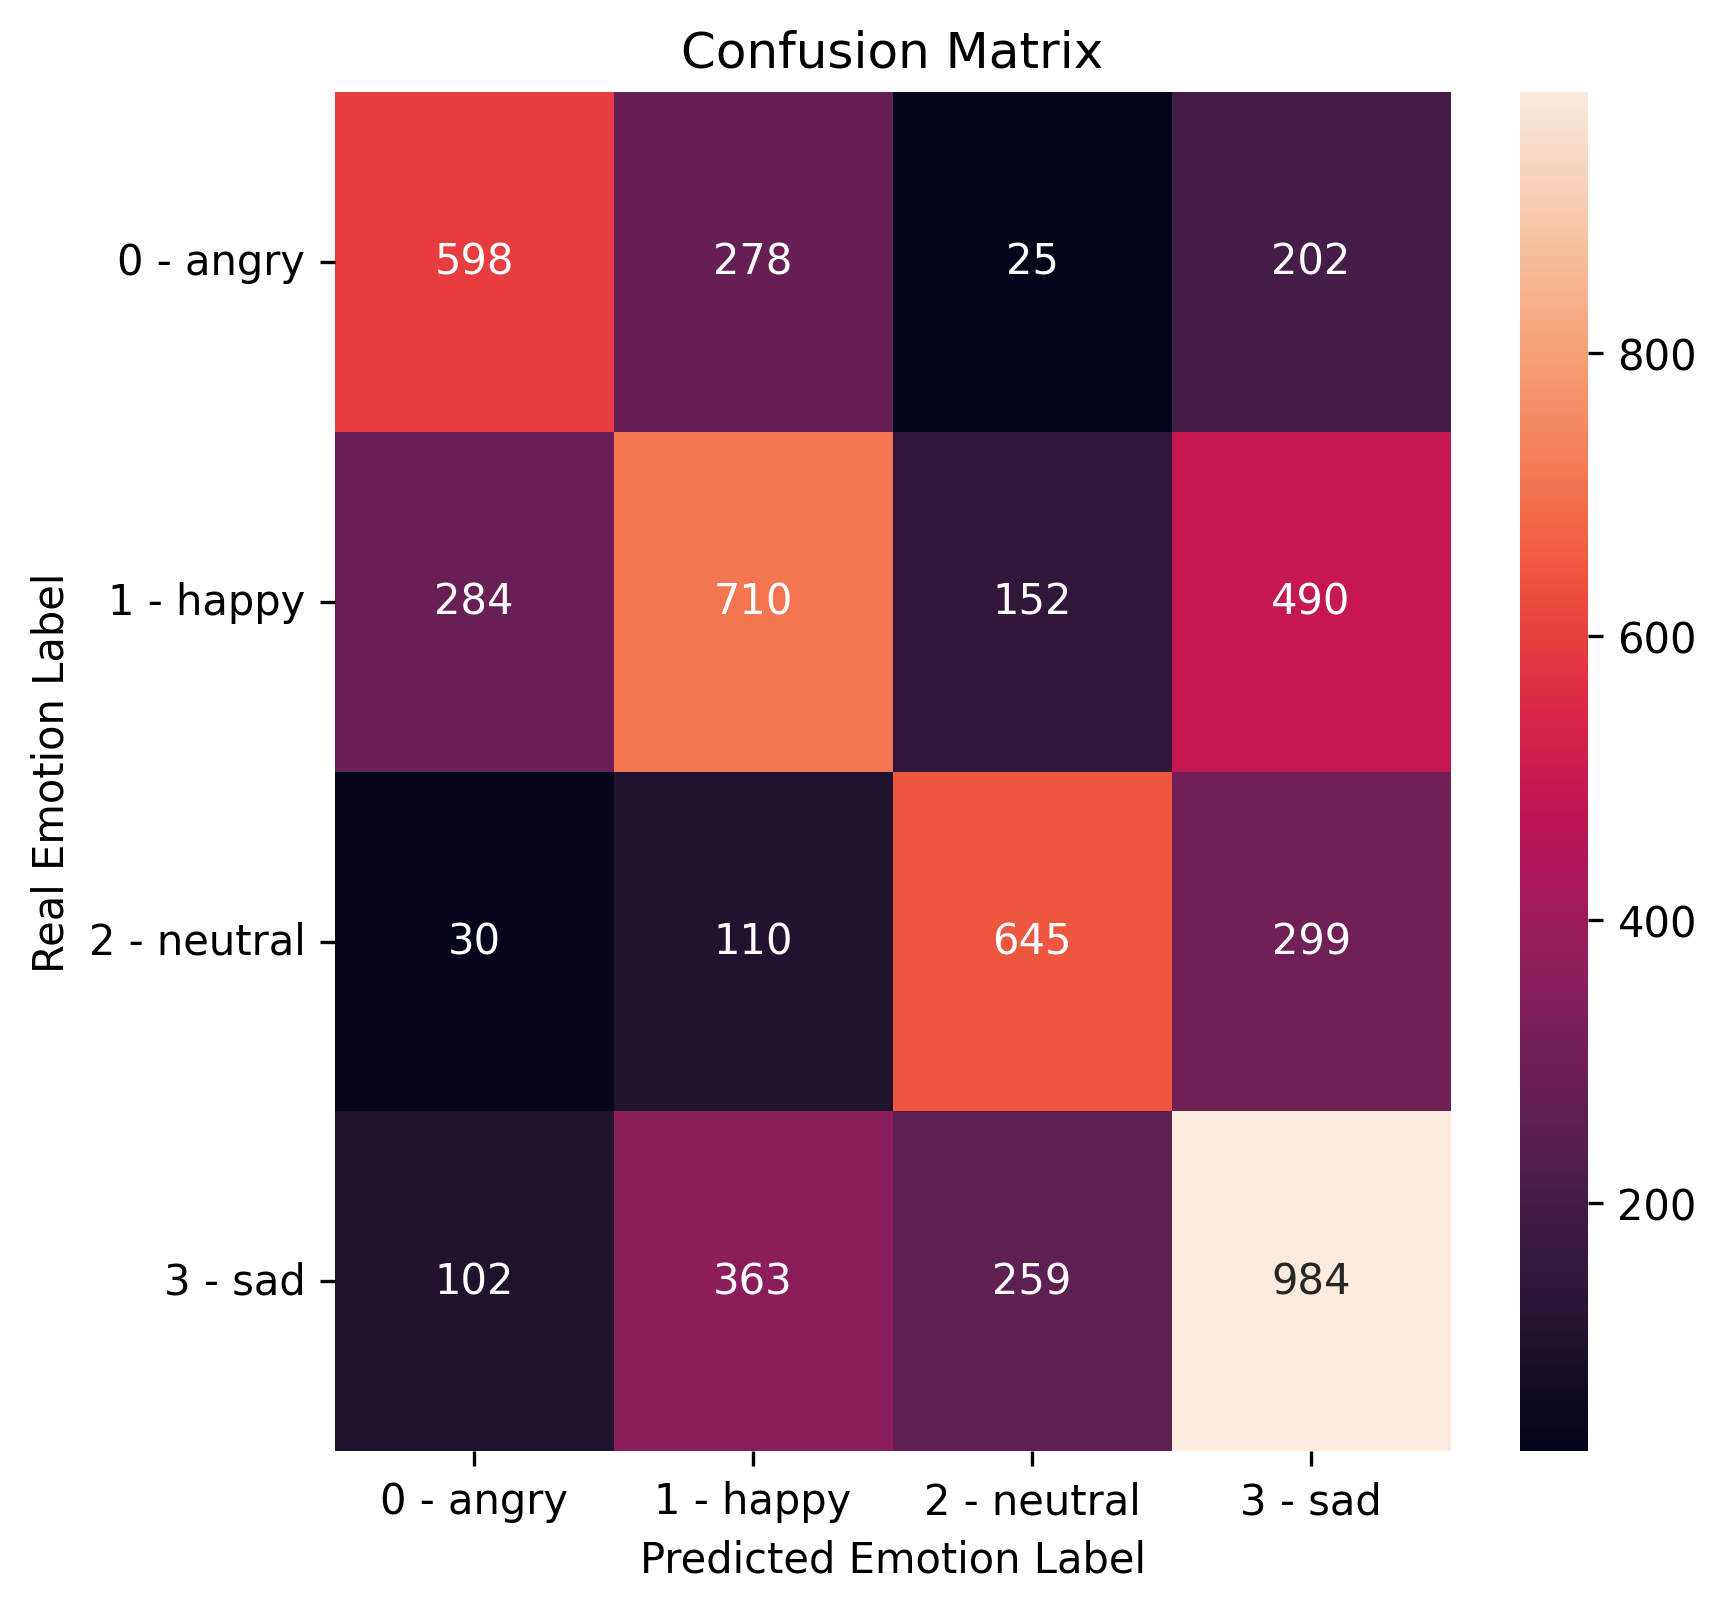

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)

# Spectrogram

In [ ]:
%cd ./data/spectrograms_images
data_df = pd.DataFrame([(file, file[-5]) for file in glob("*.png")])
print(len(data_df))
data_df.head()

/content/drive/MyDrive/Audio_Sentiment_Analysis/iemocap/data/spectrograms_images
5531


,0,1
0,Ses05F_impro06_F007-2-spec_img.png,g
1,Ses05F_impro06_F006-2-spec_img.png,g
2,Ses05F_impro06_F004-2-spec_img.png,g
3,Ses05F_impro06_F003-2-spec_img.png,g
4,Ses05F_impro06_F005-2-spec_img.png,g


## Resnet50

In [ ]:
def get_new_model():
    model = tf.keras.applications.resnet.ResNet50(
        weights="imagenet",
        input_shape=(224, 224, 3),
        include_top=False,
        pooling="avg")
    model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = model(inputs, training=False)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

def tf_load_process_image(filename):
    image_original = load_img(filename, target_size=(224, 224))
    image_array = img_to_array(image_original)
    image_preprocessed = tf.keras.applications.resnet50.preprocess_input(
        image_array)
    return image_preprocessed

get_new_model().summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_40 (Dense)            (None, 64)                131136    
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 4)                 260       
                                                                 
Total params: 23,719,108
Trainable params: 131,396
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 80
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/80
35/35 [==============================] - 24s 517ms/step - loss: 1.3676 - accuracy: 0.3791 - val_loss: 1.1555 - val_accuracy: 0.4752
Epoch 2/80
35/35 [==============================] - 2s 69ms/step - loss: 1.1654 - accuracy: 0.4462 - val_loss: 1.1301 - val_accuracy: 0.5023
Epoch 3/80
35/35 [==============================] - 2s 68ms/step - loss: 1.1340 - accuracy: 0.4620 - val_loss: 1.1087 - val_accuracy: 0.5158
Epoch 4/80
35/35 [==============================] - 2s 69ms/step - loss: 1.0986 - accuracy: 0.4907 - val_loss: 1.1011 - val_accuracy: 0.5248
Epoch 5/80
34/35 [============================>.] - ETA: 0s - loss: 1.0958 - accuracy: 0.5002
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
35/35 [==============================] - 2s 69ms/step - loss: 1.0956 - accuracy: 0.4995 - val_loss: 1.0825 - val_accuracy: 0.5348
Epoch 6/80
35/35 [==============================] - 2s 69ms/step - loss: 1.0789 - accuracy: 0.4925 - v

Accuracy for fold 0: 56.28%
Accuracy for fold 1: 62.12%
Accuracy for fold 2: 58.59%
Accuracy for fold 3: 55.97%
Accuracy for fold 4: 58.23%

Metric             Value
-----------------  -------------
Accuracy           58.24+-2.2
F1 score macro     58.97
Precision          59.38
Recall             59.0
Matthews corrcoef  0.436
Training Time      1047.72+-1.45
Prediction Time    20.78+-0.18

              precision    recall  f1-score   support

           0       0.62      0.64      0.63      1103
           1       0.57      0.47      0.51      1636
           2       0.65      0.62      0.64      1084
           3       0.53      0.63      0.58      1708

    accuracy                           0.58      5531
   macro avg       0.59      0.59      0.59      5531
weighted avg       0.58      0.58      0.58      5531



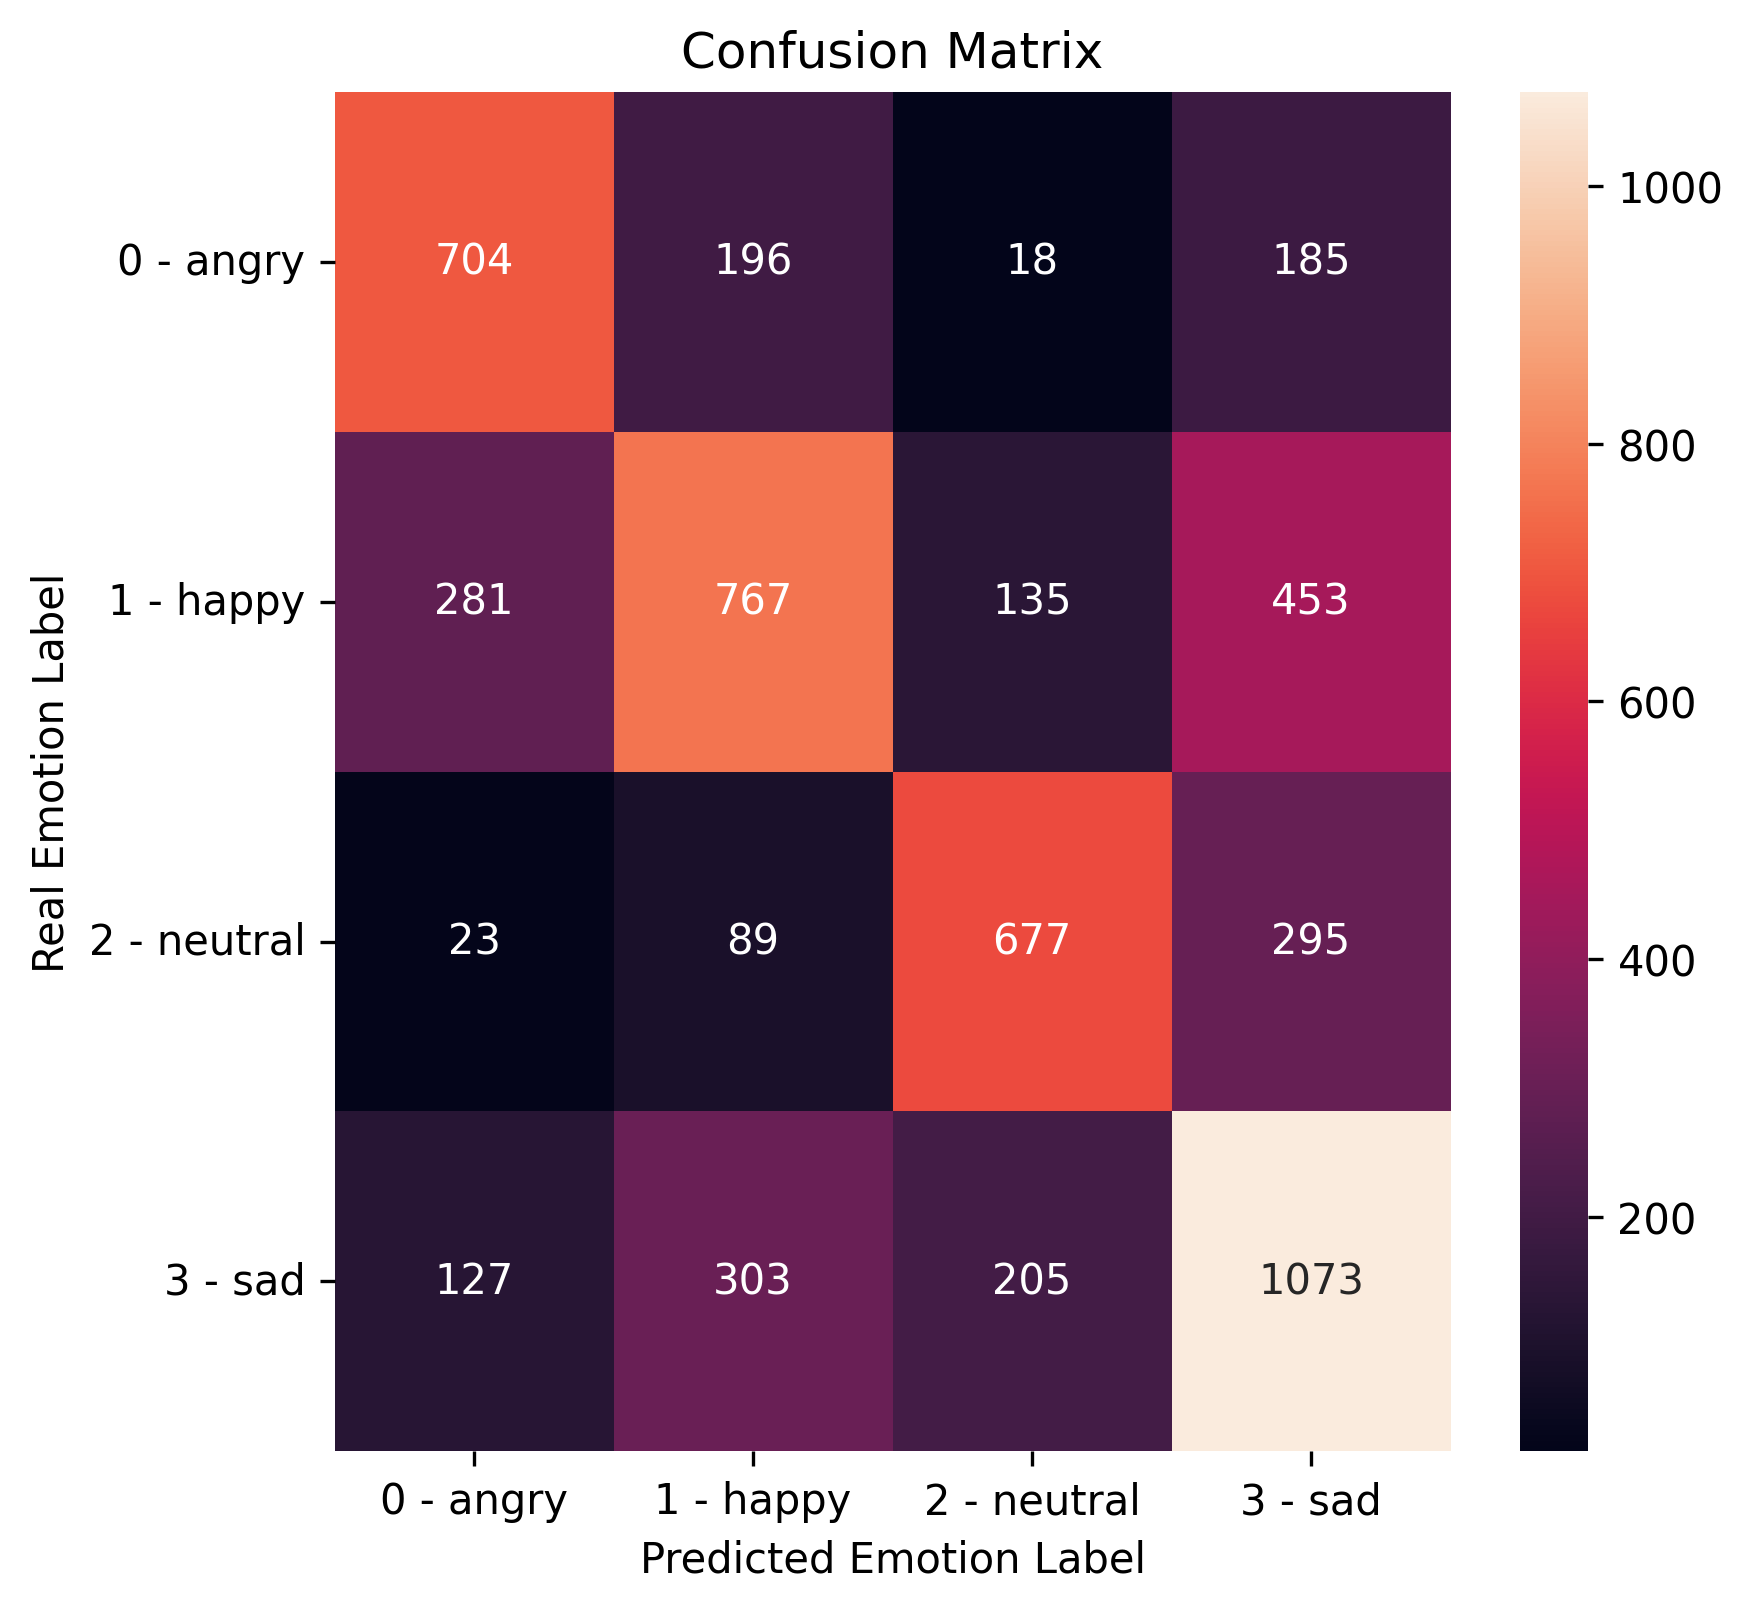

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)

## VGG16

In [ ]:
def get_new_model():
    model = tf.keras.applications.VGG16(
        weights="imagenet",
        input_shape=(224, 224, 3),
        include_top=False,
        pooling="avg")
    model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = model(inputs, training=False)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

def tf_load_process_image(filename):
    image_original = load_img(filename, target_size=(224, 224))
    image_array = img_to_array(image_original)
    image_preprocessed = tf.keras.applications.vgg16.preprocess_input(
        image_array)
    return image_preprocessed

get_new_model().summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 14,747,780
Trainable params: 33,092
Non-trainable params: 14,714,688
_____________________________________________

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 80
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/80
35/35 [==============================] - 105s 2s/step - loss: 2.9239 - accuracy: 0.3108 - val_loss: 1.2649 - val_accuracy: 0.3785
Epoch 2/80
35/35 [==============================] - 2s 68ms/step - loss: 1.2977 - accuracy: 0.3743 - val_loss: 1.1938 - val_accuracy: 0.4417
Epoch 3/80
35/35 [==============================] - 2s 67ms/step - loss: 1.2369 - accuracy: 0.3967 - val_loss: 1.1549 - val_accuracy: 0.4697
Epoch 4/80
35/35 [==============================] - 2s 67ms/step - loss: 1.2148 - accuracy: 0.4064 - val_loss: 1.1379 - val_accuracy: 0.4923
Epoch 5/80
34/35 [============================>.] - ETA: 0s - loss: 1.1852 - accuracy: 0.4334
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
35/35 [==============================] - 2s 68ms/step - loss: 1.1837 - accuracy: 0.4349 - val_loss: 1.1201 - val_accuracy: 0.4959
Epoch 6/80
35/35 [==============================] - 2s 67ms/step - loss: 1.1701 - accuracy: 0.4394 - val

Accuracy for fold 0: 55.19%
Accuracy for fold 1: 54.61%
Accuracy for fold 2: 55.06%
Accuracy for fold 3: 52.8%
Accuracy for fold 4: 53.71%

Metric             Value
-----------------  --------------
Accuracy           54.28+-0.9
F1 score macro     55.21
Precision          55.85
Recall             54.87
Matthews corrcoef  0.379
Training Time      1147.05+-49.56
Prediction Time    12.16+-0.42

              precision    recall  f1-score   support

           0       0.61      0.53      0.57      1103
           1       0.50      0.47      0.48      1636
           2       0.62      0.63      0.63      1084
           3       0.50      0.57      0.53      1708

    accuracy                           0.54      5531
   macro avg       0.56      0.55      0.55      5531
weighted avg       0.55      0.54      0.54      5531



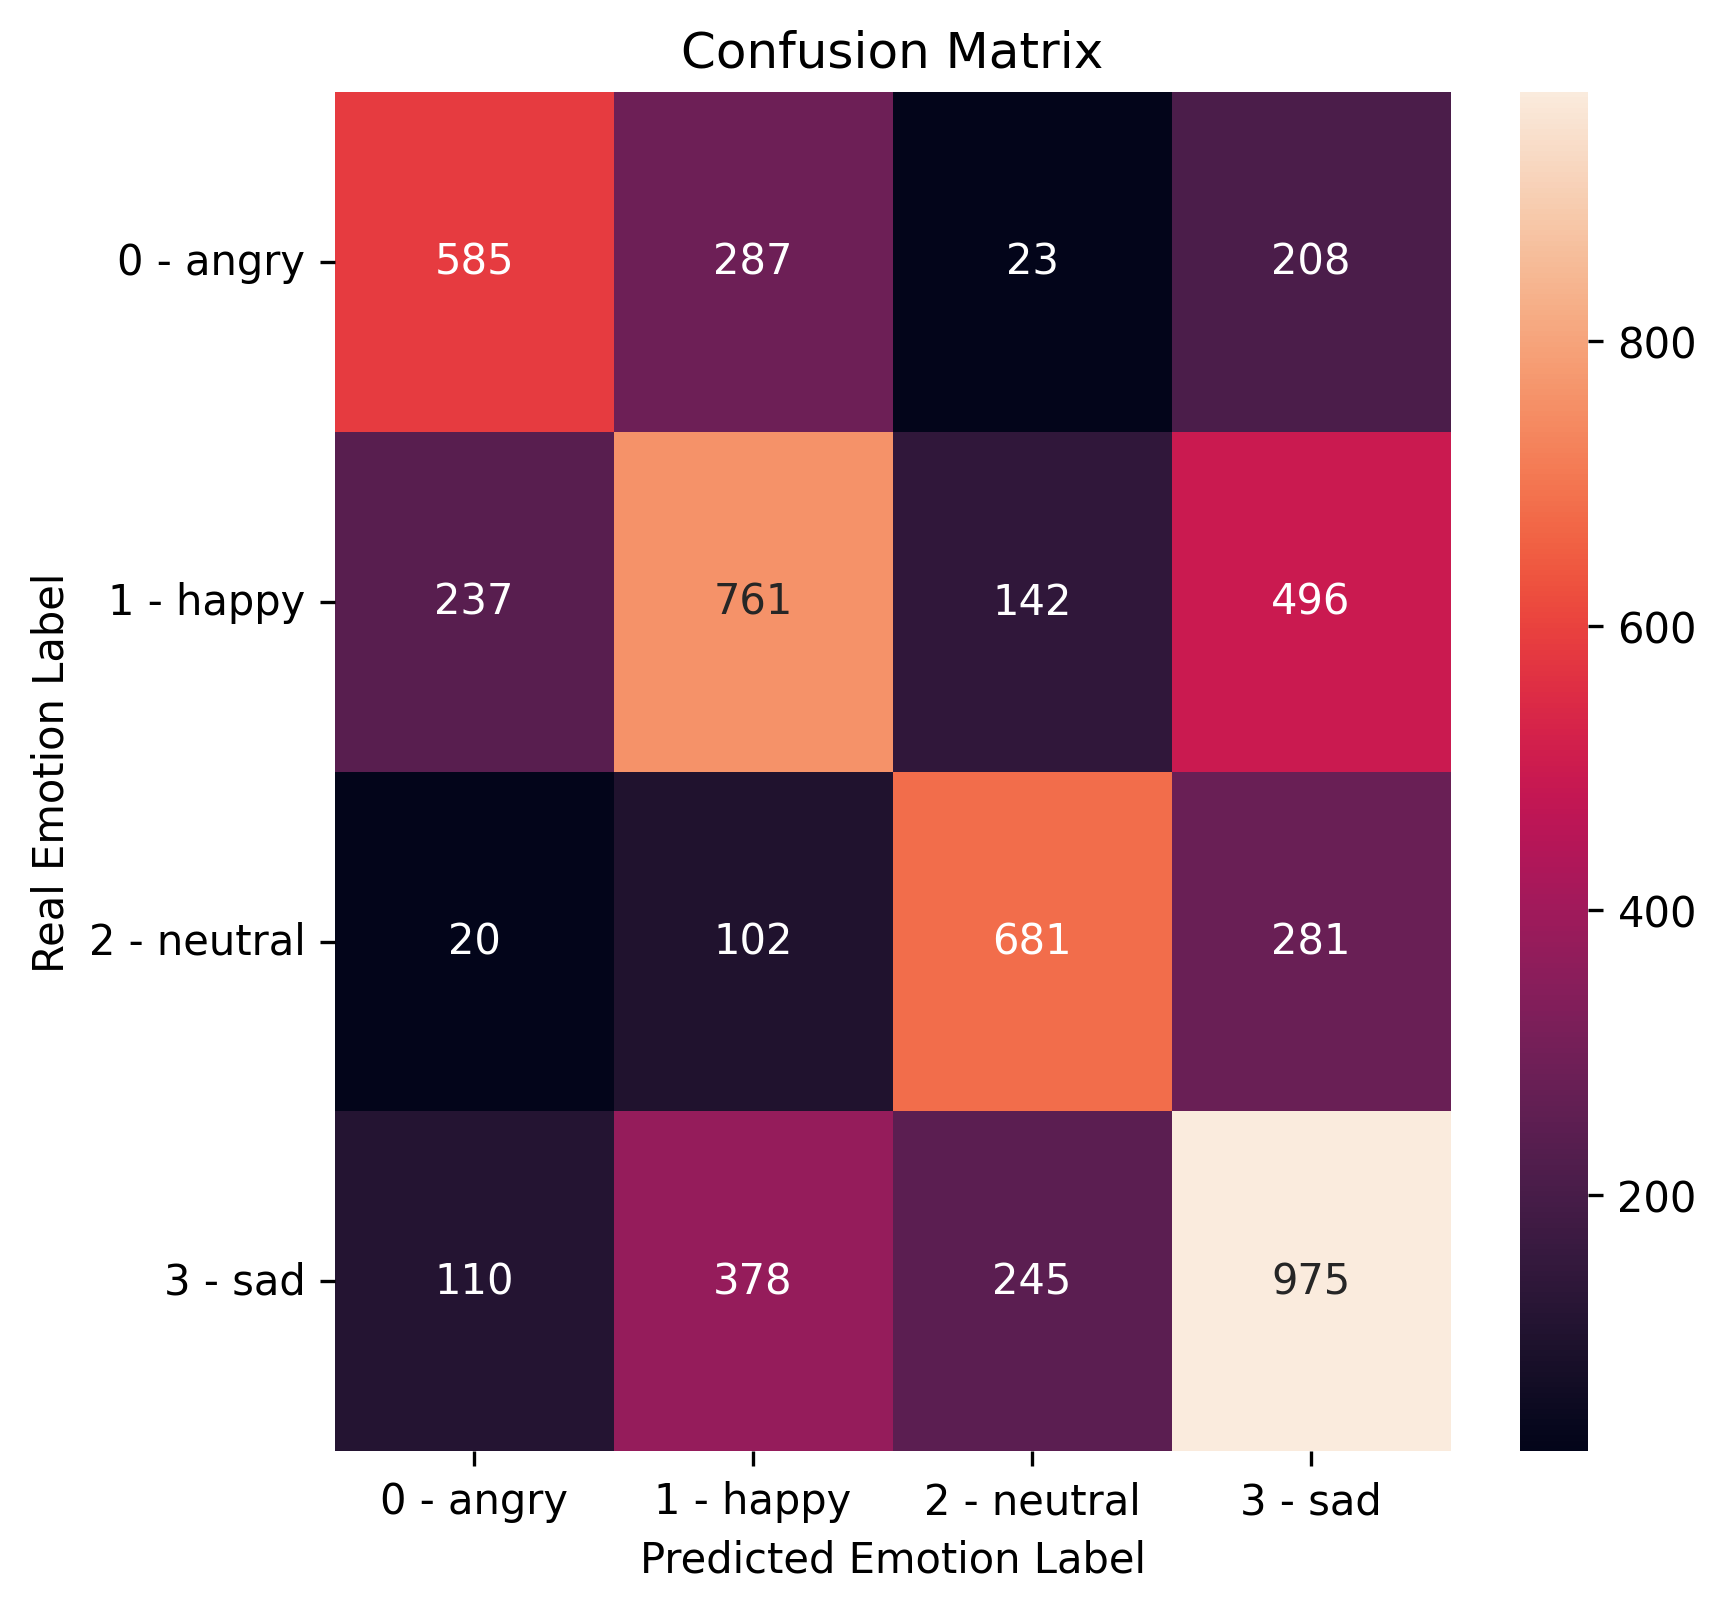

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)

## Xception

In [ ]:
def get_new_model():
    model = tf.keras.applications.Xception(
        weights="imagenet",
        input_shape=(224, 224, 3),
        include_top=False,
        pooling="avg")
    model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = model(inputs, training=False)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

def tf_load_process_image(filename):
    image_original = load_img(filename, target_size=(224, 224))
    image_array = img_to_array(image_original)
    image_preprocessed = tf.keras.applications.xception.preprocess_input(
        image_array)
    return image_preprocessed

get_new_model().summary()

83683744/83683744 [==============================] - 3s 0us/step
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_12 (Dense)            (None, 64)                131136    
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 4)                 260       
                                                                 
Total params: 20,992,876
Trainable params: 131,396
Non-trainable params: 20,861,480
__________________________________________

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 80
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/80
35/35 [==============================] - 22s 495ms/step - loss: 1.2797 - accuracy: 0.3775 - val_loss: 1.1583 - val_accuracy: 0.4761
Epoch 2/80
35/35 [==============================] - 3s 78ms/step - loss: 1.1916 - accuracy: 0.4442 - val_loss: 1.1420 - val_accuracy: 0.4968
Epoch 3/80
35/35 [==============================] - 3s 78ms/step - loss: 1.1613 - accuracy: 0.4720 - val_loss: 1.1267 - val_accuracy: 0.5077
Epoch 4/80
35/35 [==============================] - 3s 79ms/step - loss: 1.1472 - accuracy: 0.4736 - val_loss: 1.1071 - val_accuracy: 0.5176
Epoch 5/80
34/35 [============================>.] - ETA: 0s - loss: 1.1281 - accuracy: 0.4775
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
35/35 [==============================] - 3s 79ms/step - loss: 1.1267 - accuracy: 0.4778 - val_loss: 1.1030 - val_accuracy: 0.5230
Epoch 6/80
35/35 [==============================] - 3s 78ms/step - loss: 1.1173 - accuracy: 0.4930 - v

Accuracy for fold 0: 54.92%
Accuracy for fold 1: 50.9%
Accuracy for fold 2: 51.18%
Accuracy for fold 3: 53.07%
Accuracy for fold 4: 53.8%

Metric             Value
-----------------  -------------
Accuracy           52.78+-1.54
F1 score macro     53.51
Precision          53.48
Recall             53.62
Matthews corrcoef  0.361
Training Time      1190.07+-2.63
Prediction Time    19.55+-0.24

              precision    recall  f1-score   support

           0       0.58      0.55      0.56      1103
           1       0.49      0.45      0.47      1636
           2       0.57      0.61      0.59      1084
           3       0.51      0.53      0.52      1708

    accuracy                           0.53      5531
   macro avg       0.53      0.54      0.54      5531
weighted avg       0.53      0.53      0.53      5531



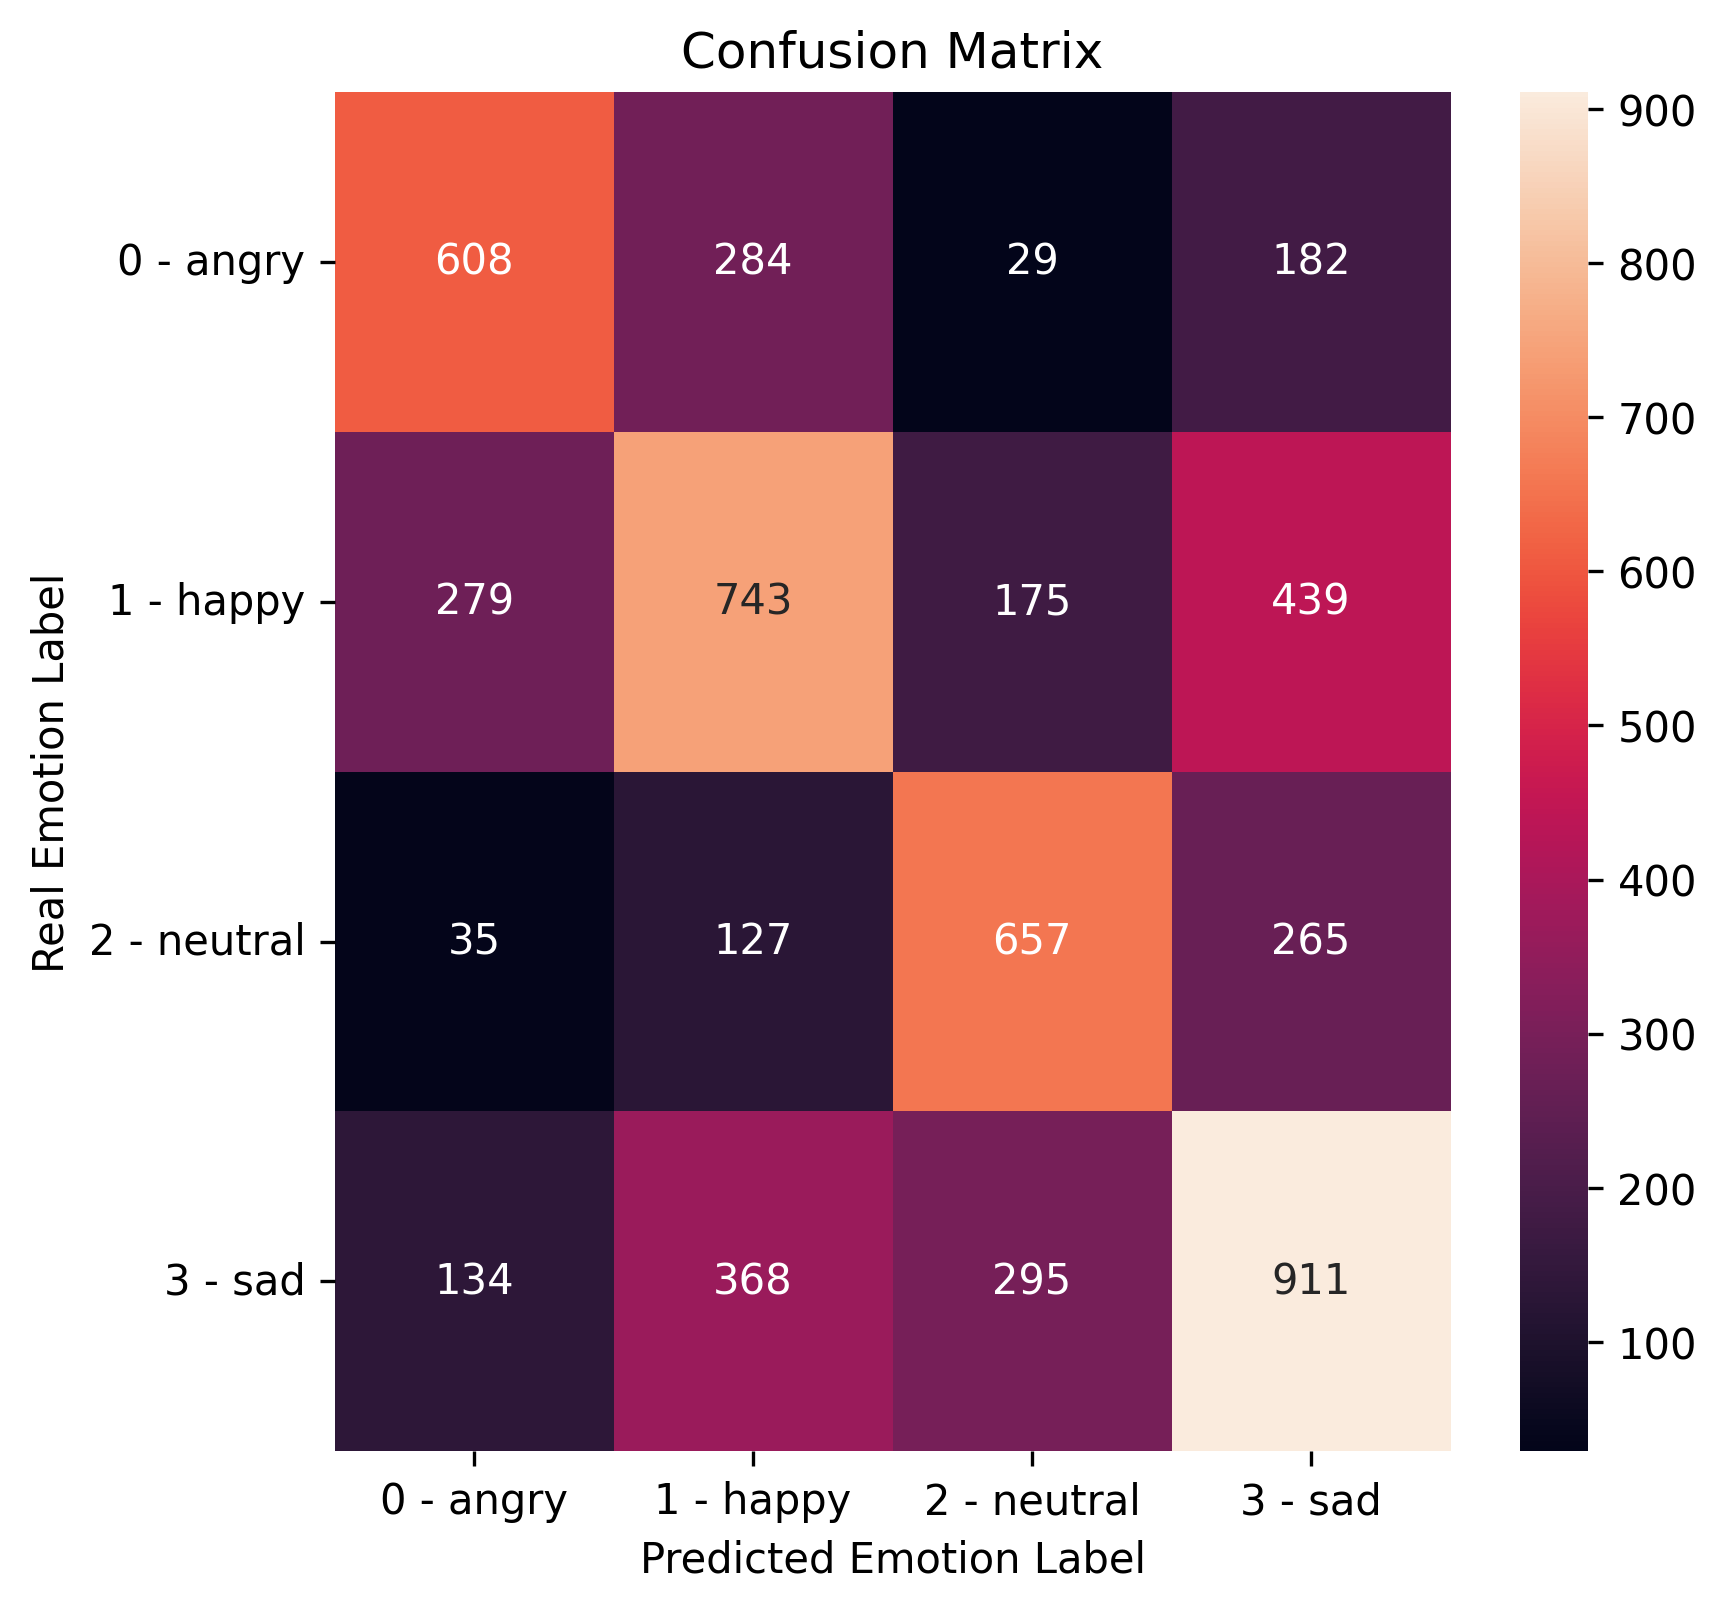

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)

# MFCCs

In [ ]:
%cd ./data/mfccs_images
data_df = pd.DataFrame([(file, file[-5]) for file in glob("*.png")])
print(len(data_df))
data_df.head()

[Errno 2] No such file or directory: './data/mfccs_images'
/content/drive/MyDrive/Audio_Sentiment_Analysis/iemocap/data/spectrograms_images
5531


,0,1
0,Ses05F_impro06_F007-2-spec_img.png,g
1,Ses05F_impro06_F006-2-spec_img.png,g
2,Ses05F_impro06_F004-2-spec_img.png,g
3,Ses05F_impro06_F003-2-spec_img.png,g
4,Ses05F_impro06_F005-2-spec_img.png,g


## Resnet50

In [ ]:
def get_new_model():
    model = tf.keras.applications.resnet.ResNet50(
        weights="imagenet",
        input_shape=(224, 224, 3),
        include_top=False,
        pooling="avg")
    model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = model(inputs, training=False)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

def tf_load_process_image(filename):
    image_original = load_img(filename, target_size=(224, 224))
    image_array = img_to_array(image_original)
    image_preprocessed = tf.keras.applications.resnet50.preprocess_input(
        image_array)
    return image_preprocessed

get_new_model().summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_24 (Dense)            (None, 64)                131136    
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 4)                 260       
                                                                 
Total params: 23,719,108
Trainable params: 131,396
Non-trainable params: 23,587,712
_________________________________________

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 80
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/80
35/35 [==============================] - 24s 490ms/step - loss: 1.4966 - accuracy: 0.3266 - val_loss: 1.2370 - val_accuracy: 0.4390
Epoch 2/80
35/35 [==============================] - 2s 67ms/step - loss: 1.2639 - accuracy: 0.3755 - val_loss: 1.1664 - val_accuracy: 0.4553
Epoch 3/80
35/35 [==============================] - 2s 68ms/step - loss: 1.2207 - accuracy: 0.3947 - val_loss: 1.1481 - val_accuracy: 0.4896
Epoch 4/80
35/35 [==============================] - 2s 68ms/step - loss: 1.1979 - accuracy: 0.4252 - val_loss: 1.1108 - val_accuracy: 0.5041
Epoch 5/80
34/35 [============================>.] - ETA: 0s - loss: 1.1691 - accuracy: 0.4382
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
35/35 [==============================] - 2s 68ms/step - loss: 1.1688 - accuracy: 0.4372 - val_loss: 1.1079 - val_accuracy: 0.5122
Epoch 6/80
35/35 [==============================] - 2s 68ms/step - loss: 1.1635 - accuracy: 0.4516 - v

Accuracy for fold 0: 56.73%
Accuracy for fold 1: 56.24%
Accuracy for fold 2: 57.41%
Accuracy for fold 3: 56.33%
Accuracy for fold 4: 56.24%

Metric             Value
-----------------  -------------
Accuracy           56.59+-0.45
F1 score macro     57.29
Precision          58.59
Recall             56.67
Matthews corrcoef  0.41
Training Time      1044.96+-0.92
Prediction Time    23.19+-0.33

              precision    recall  f1-score   support

           0       0.64      0.57      0.60      1103
           1       0.52      0.47      0.49      1636
           2       0.66      0.59      0.62      1084
           3       0.52      0.65      0.57      1708

    accuracy                           0.57      5531
   macro avg       0.59      0.57      0.57      5531
weighted avg       0.57      0.57      0.57      5531



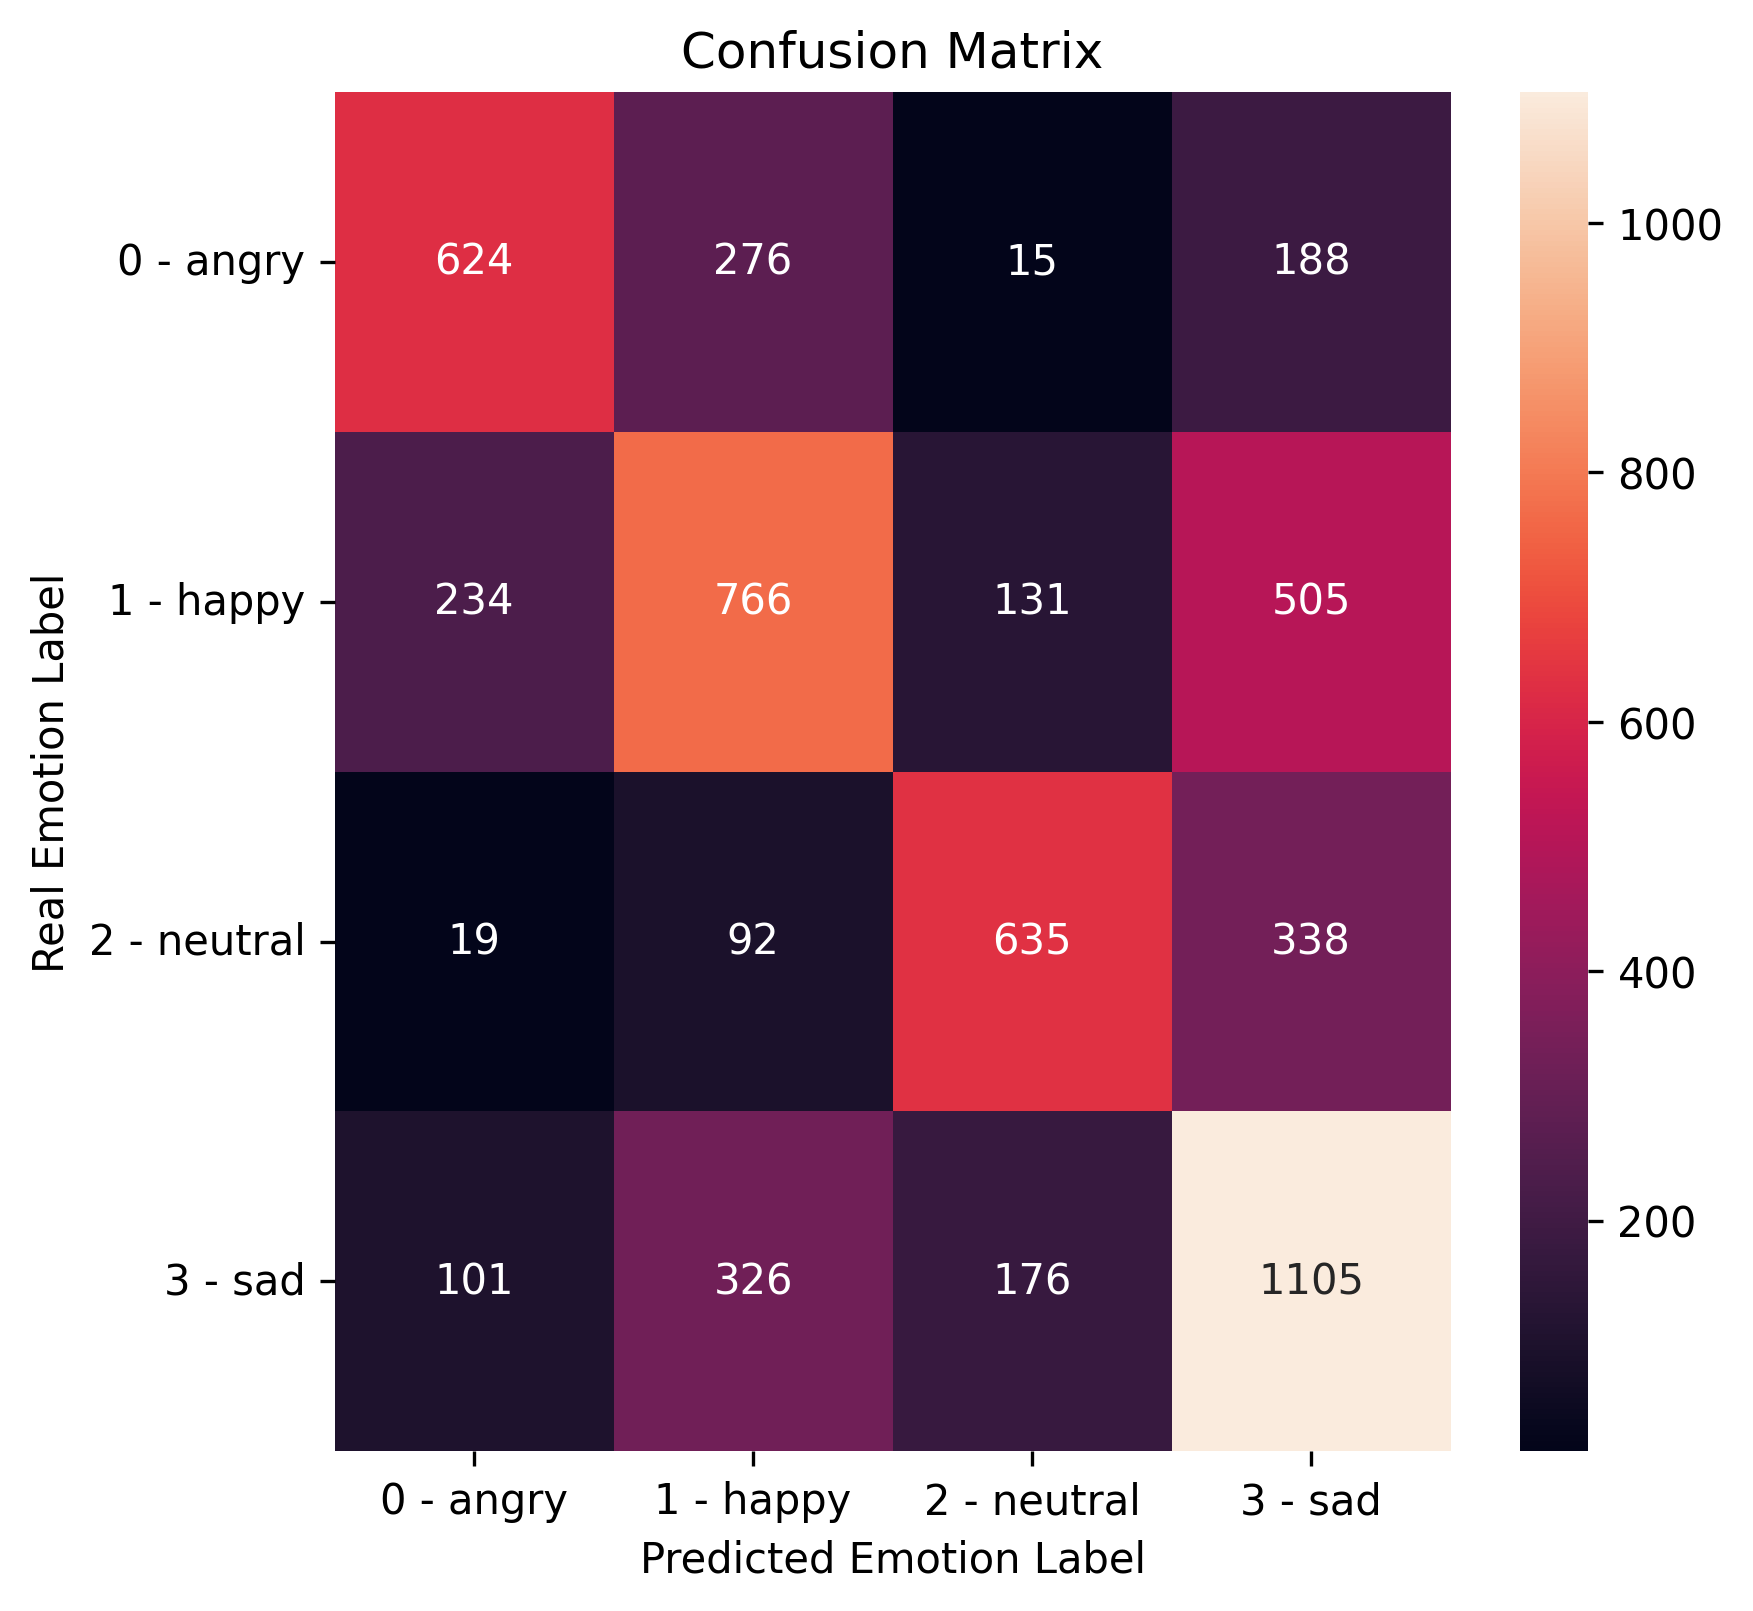

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)

## VGG16

In [ ]:
def get_new_model():
    model = tf.keras.applications.VGG16(
        weights="imagenet",
        input_shape=(224, 224, 3),
        include_top=False,
        pooling="avg")
    model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = model(inputs, training=False)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

def tf_load_process_image(filename):
    image_original = load_img(filename, target_size=(224, 224))
    image_array = img_to_array(image_original)
    image_preprocessed = tf.keras.applications.vgg16.preprocess_input(
        image_array)
    return image_preprocessed

get_new_model().summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_36 (Dense)            (None, 64)                32832     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 4)                 260       
                                                                 
Total params: 14,747,780
Trainable params: 33,092
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 80
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/80
35/35 [==============================] - 18s 463ms/step - loss: 2.4023 - accuracy: 0.3011 - val_loss: 1.3114 - val_accuracy: 0.3957
Epoch 2/80
35/35 [==============================] - 2s 69ms/step - loss: 1.2893 - accuracy: 0.3784 - val_loss: 1.2228 - val_accuracy: 0.4173
Epoch 3/80
35/35 [==============================] - 2s 69ms/step - loss: 1.2582 - accuracy: 0.4010 - val_loss: 1.1801 - val_accuracy: 0.4300
Epoch 4/80
35/35 [==============================] - 2s 68ms/step - loss: 1.2069 - accuracy: 0.4326 - val_loss: 1.1562 - val_accuracy: 0.4634
Epoch 5/80
34/35 [============================>.] - ETA: 0s - loss: 1.1865 - accuracy: 0.4430
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
35/35 [==============================] - 2s 69ms/step - loss: 1.1855 - accuracy: 0.4435 - val_loss: 1.1373 - val_accuracy: 0.4761
Epoch 6/80
35/35 [==============================] - 2s 69ms/step - loss: 1.1579 - accuracy: 0.4561 - v

Accuracy for fold 0: 55.37%
Accuracy for fold 1: 54.52%
Accuracy for fold 2: 56.96%
Accuracy for fold 3: 52.44%
Accuracy for fold 4: 54.34%

Metric             Value
-----------------  ------------
Accuracy           54.73+-1.47
F1 score macro     55.51
Precision          56.32
Recall             55.14
Matthews corrcoef  0.386
Training Time      1032.96+-1.1
Prediction Time    10.89+-0.06

              precision    recall  f1-score   support

           0       0.63      0.56      0.59      1103
           1       0.52      0.46      0.48      1636
           2       0.61      0.59      0.60      1084
           3       0.50      0.60      0.54      1708

    accuracy                           0.55      5531
   macro avg       0.56      0.55      0.56      5531
weighted avg       0.55      0.55      0.55      5531



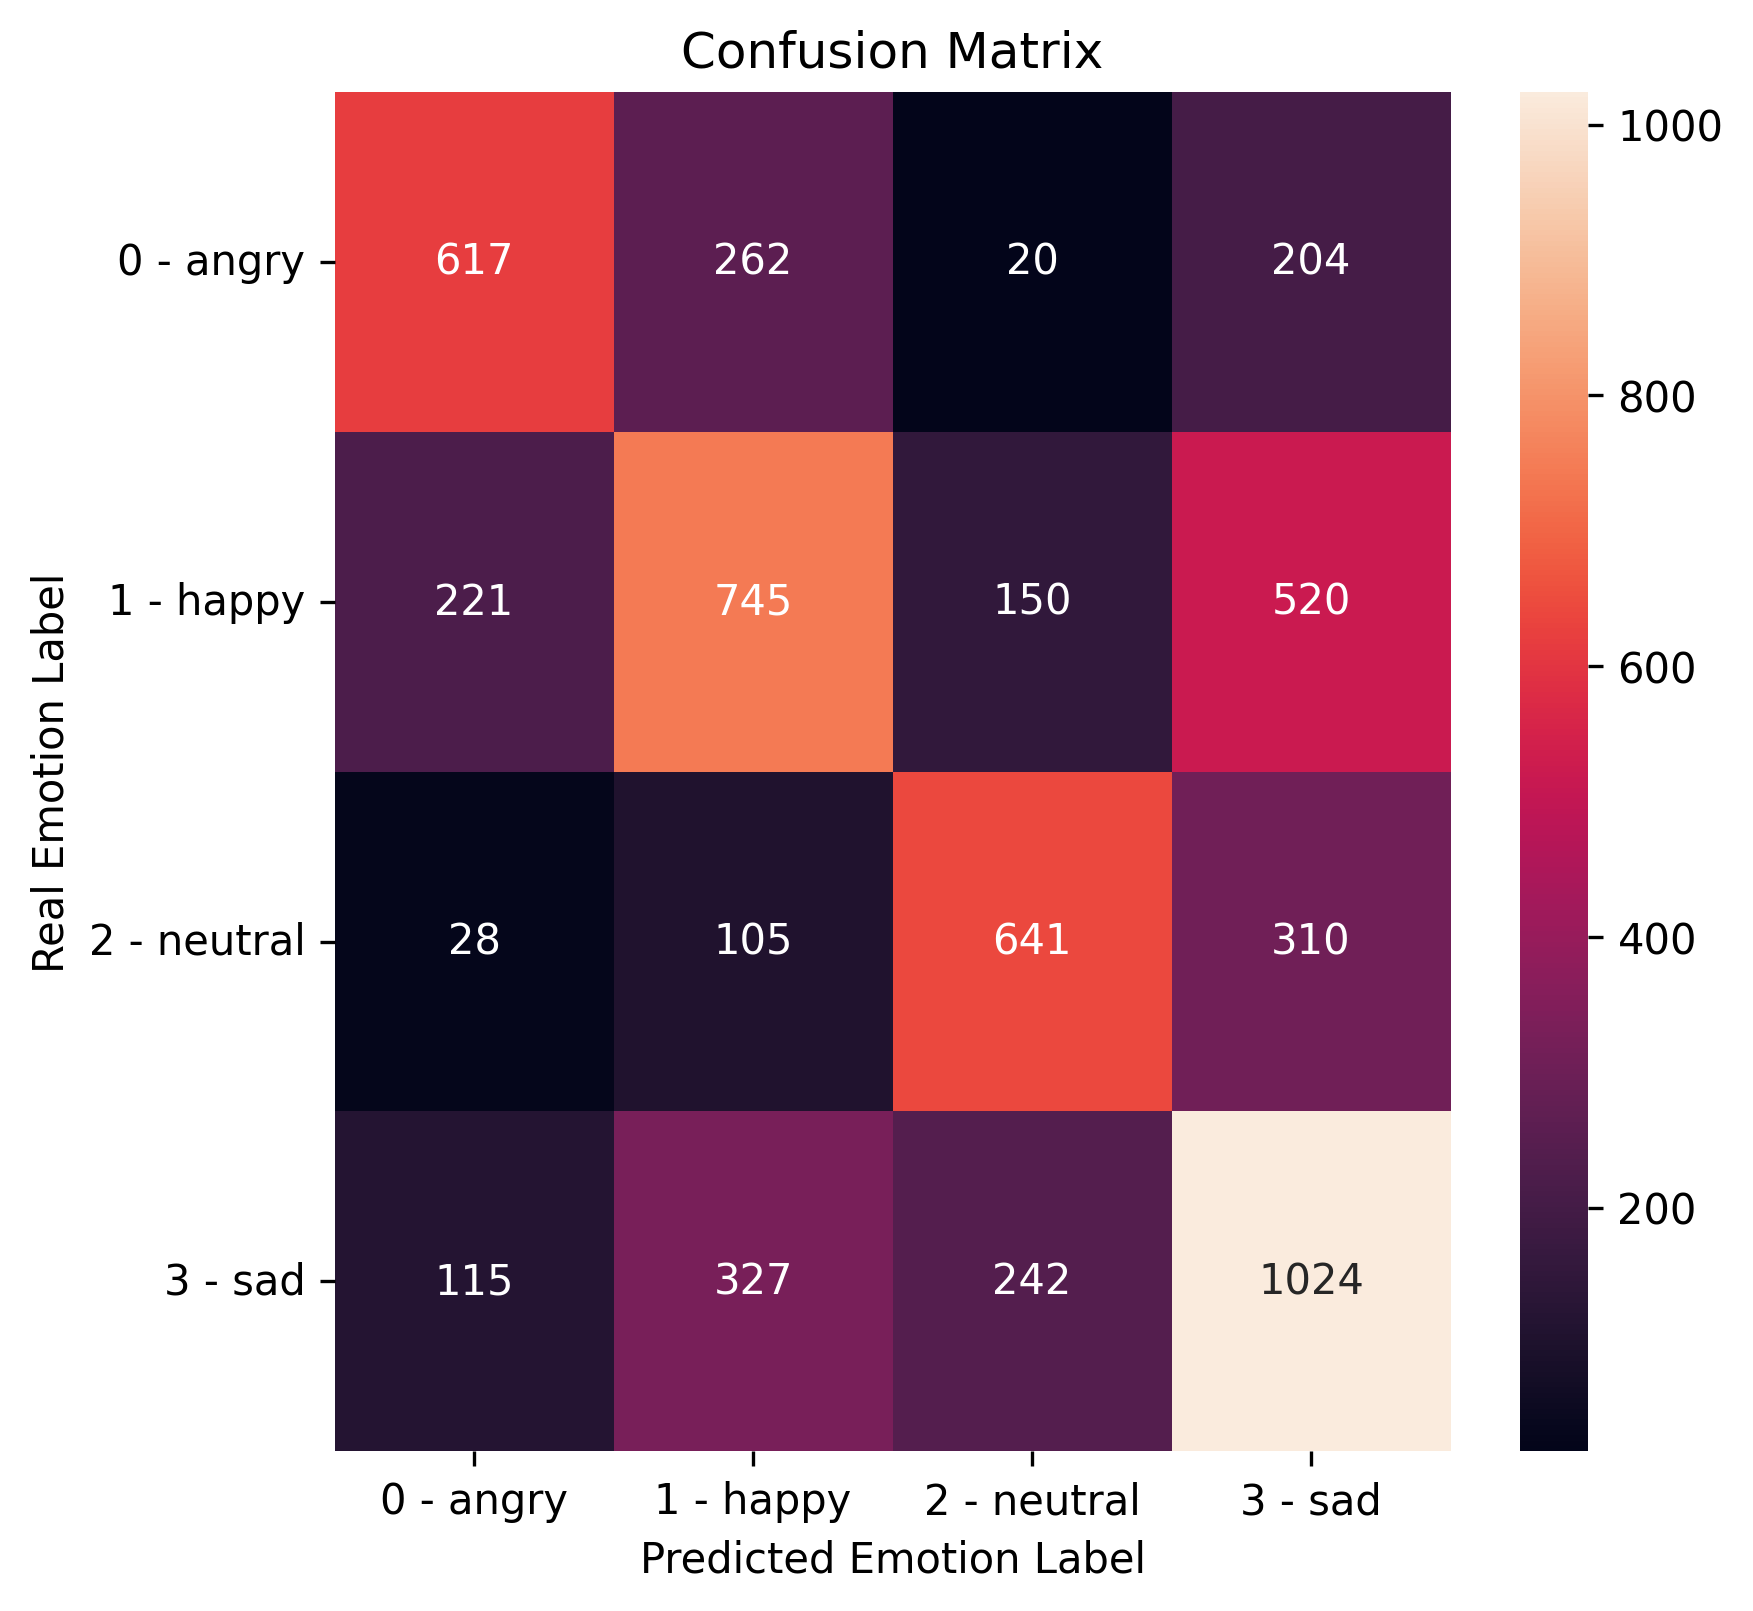

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)

## Xception

In [ ]:
def get_new_model():
    model = tf.keras.applications.Xception(
        weights="imagenet",
        input_shape=(224, 224, 3),
        include_top=False,
        pooling="avg")
    model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = model(inputs, training=False)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

def tf_load_process_image(filename):
    image_original = load_img(filename, target_size=(224, 224))
    image_array = img_to_array(image_original)
    image_preprocessed = tf.keras.applications.xception.preprocess_input(
        image_array)
    return image_preprocessed

get_new_model().summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_48 (Dense)            (None, 64)                131136    
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 4)                 260       
                                                                 
Total params: 20,992,876
Trainable params: 131,396
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 80
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/80
35/35 [==============================] - 20s 470ms/step - loss: 1.2710 - accuracy: 0.3910 - val_loss: 1.1650 - val_accuracy: 0.4670
Epoch 2/80
35/35 [==============================] - 3s 79ms/step - loss: 1.1931 - accuracy: 0.4396 - val_loss: 1.1360 - val_accuracy: 0.4688
Epoch 3/80
35/35 [==============================] - 3s 79ms/step - loss: 1.1694 - accuracy: 0.4530 - val_loss: 1.1208 - val_accuracy: 0.4788
Epoch 4/80
35/35 [==============================] - 3s 79ms/step - loss: 1.1477 - accuracy: 0.4618 - val_loss: 1.1158 - val_accuracy: 0.4797
Epoch 5/80
34/35 [============================>.] - ETA: 0s - loss: 1.1445 - accuracy: 0.4699
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
35/35 [==============================] - 3s 79ms/step - loss: 1.1431 - accuracy: 0.4699 - val_loss: 1.1075 - val_accuracy: 0.4806
Epoch 6/80
35/35 [==============================] - 3s 78ms/step - loss: 1.1246 - accuracy: 0.4955 - v

Accuracy for fold 0: 54.29%
Accuracy for fold 1: 51.9%
Accuracy for fold 2: 51.63%
Accuracy for fold 3: 52.8%
Accuracy for fold 4: 53.25%

Metric             Value
-----------------  -------------
Accuracy           52.78+-0.96
F1 score macro     53.47
Precision          54.1
Recall             53.22
Matthews corrcoef  0.359
Training Time      1181.58+-3.43
Prediction Time    18.33+-0.04

              precision    recall  f1-score   support

           0       0.61      0.52      0.56      1103
           1       0.49      0.45      0.47      1636
           2       0.58      0.60      0.59      1084
           3       0.49      0.57      0.53      1708

    accuracy                           0.53      5531
   macro avg       0.54      0.53      0.53      5531
weighted avg       0.53      0.53      0.53      5531



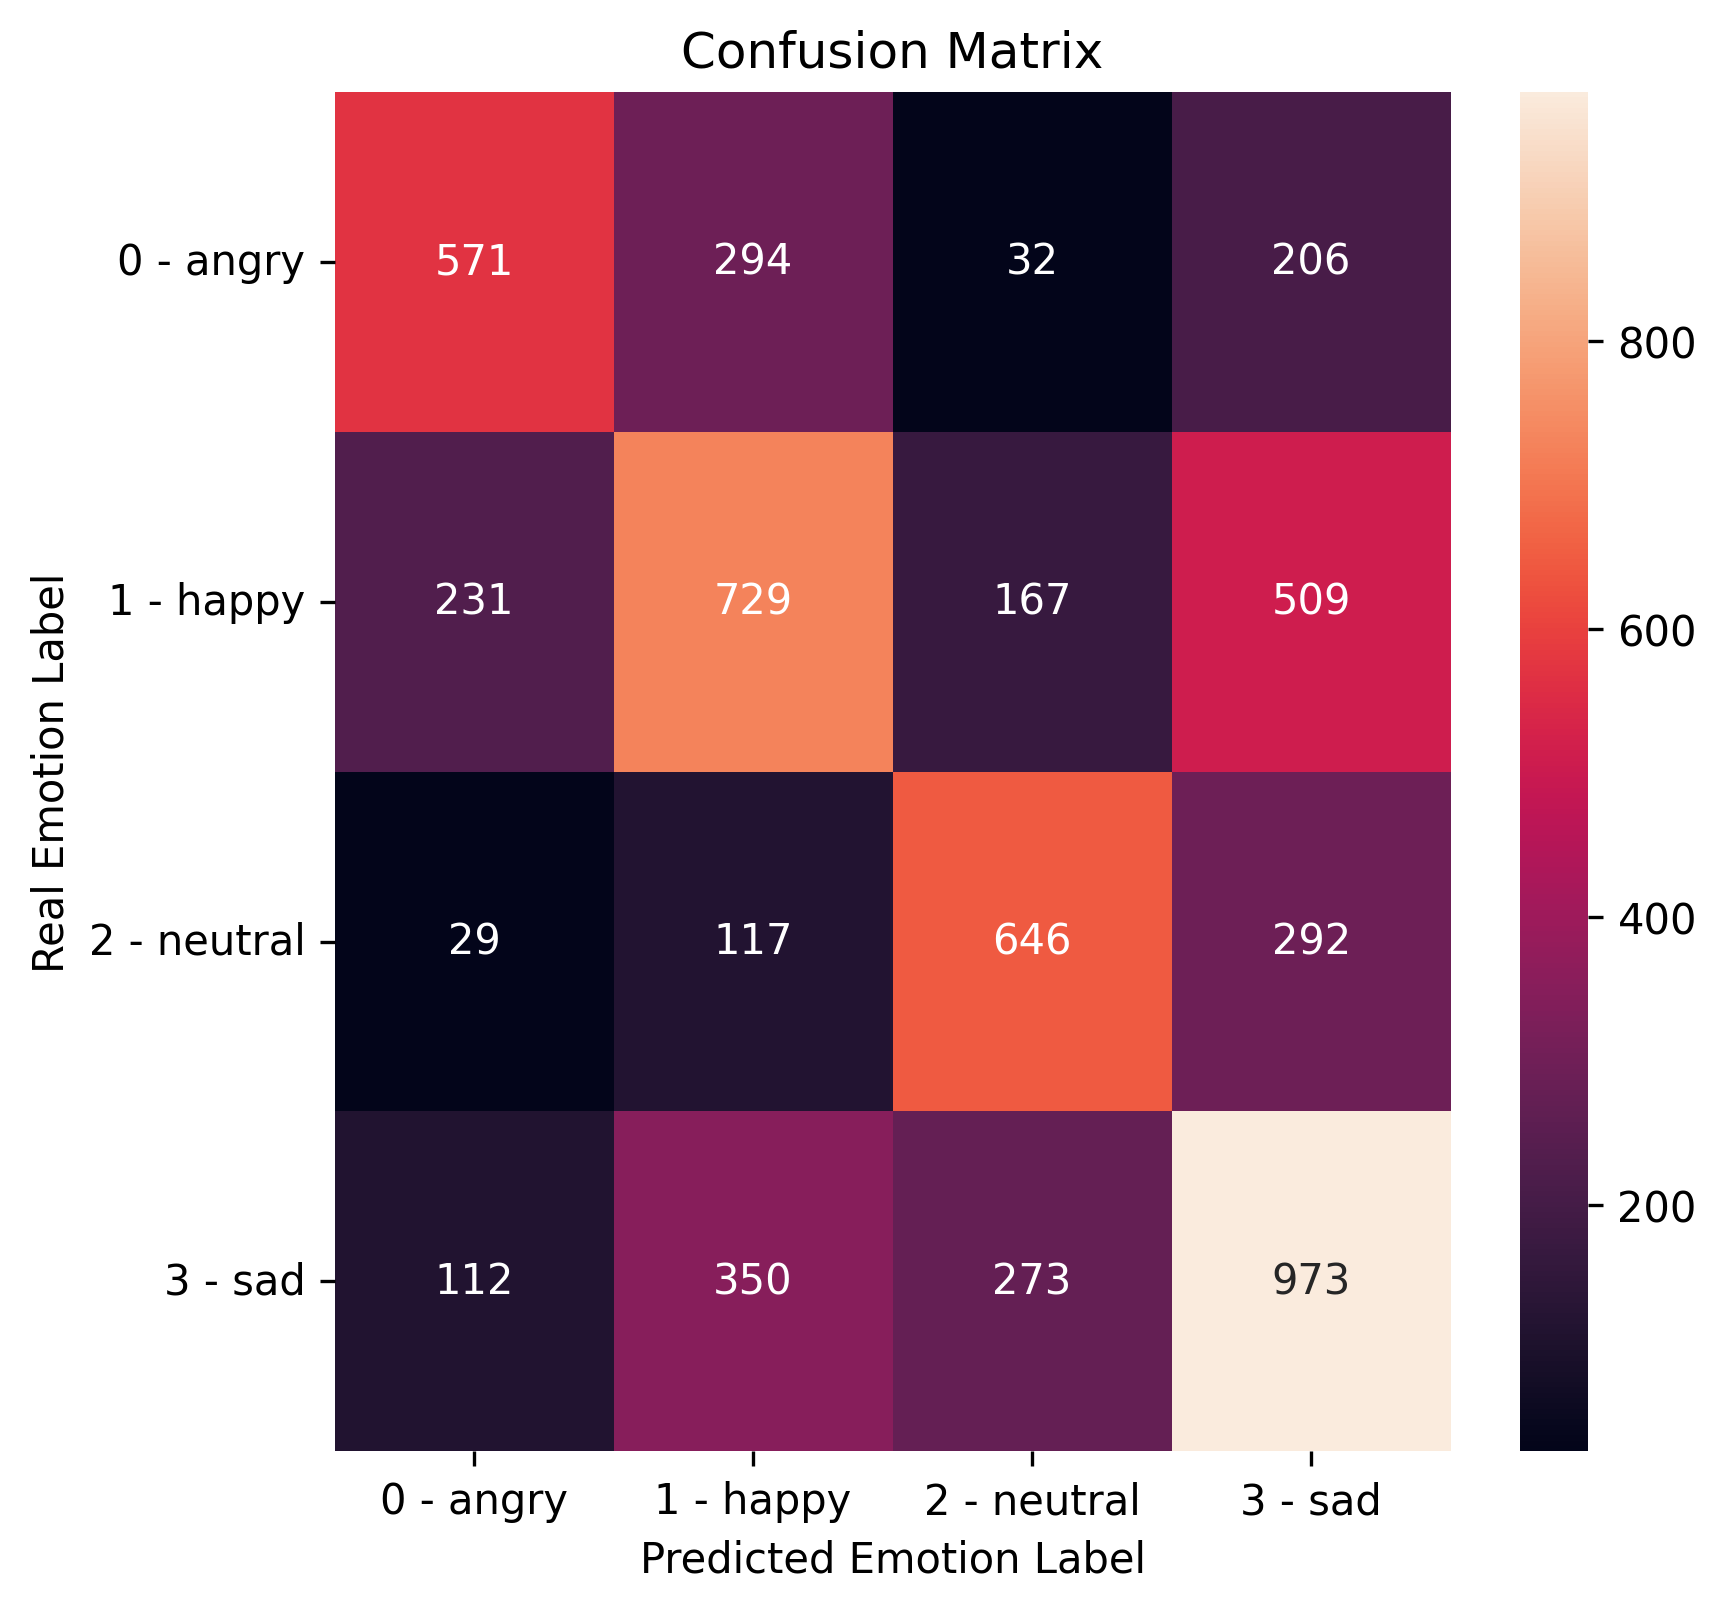

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)

In [ ]:
from google.colab import runtime
runtime.unassign()